## Mapping Women's Health Care Access & Representation in the United States by Congressional District
#####  Source: U.S. Health Resources and Services Administration (HRSA), Area Health Resources Files, 2021, https://data.hrsa.gov/data/download  
##### Source: Census file for GeoDataframes spatial analysis: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
Anna E. Feldman | INFO 696, Spring/Summer 2024 Final Project

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import contextily as cx
import geopandas as gpd
import shapely
from pointpats import centrography

### Read in file and describe characteristics

In [2]:
url="/Users/annafeldman/Desktop/INFO696/Final Files/AHRF_CSVandDocu copy/ahrf2023.csv"
df = pd.read_csv(url, encoding='latin-1')
df.head()
# Encoding latin-1 // DtypeWarning: Columns (14,16,24) have mixed types - need to specify

/var/folders/sf/whvty1j57cxcxs3t3mhwbcgh0000gn/T/ipykernel_55628/4277630068.py:2: DtypeWarning: Columns (14,16,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, encoding='latin-1')


,blank,fips_st_cnty,entity_file,secndry_entity_file,date_file,date_cretn,file_length,st_name,st_name_abbrev,cnty_name,...,dys_air_qulty_mesrd_21,dys_mesrd_air_qulty_good_22,dys_mesrd_air_qulty_good_21,good_air_qulty_dys_pct_22,good_air_qulty_dys_pct_21,annul_partclt_mattr_2_5_avg_19,annul_partclt_mattr_2_5_avg_18,dys_8_hr_ozone_over_naaqs_avg_19,dys_8_hr_ozone_over_naaqs_avg_18,elevtn_feet_76
0,NaN,1001,AHRF,1001,2023,23208,25907,Alabama,AL,Autauga,...,NaN,NaN,NaN,NaN,NaN,10.0,9.5,1.0,0.0,290.0
1,NaN,1003,AHRF,1003,2023,23208,25907,Alabama,AL,Baldwin,...,280.0,256.0,264.0,91.1,94.29,7.6,7.2,0.0,0.0,155.0
2,NaN,1005,AHRF,1005,2023,23208,25907,Alabama,AL,Barbour,...,NaN,NaN,NaN,NaN,NaN,9.4,9.0,0.0,0.0,220.0
3,NaN,1007,AHRF,1007,2023,23208,25907,Alabama,AL,Bibb,...,NaN,NaN,NaN,NaN,NaN,9.8,9.4,0.0,1.0,224.0
4,NaN,1009,AHRF,1009,2023,23208,25907,Alabama,AL,Blount,...,NaN,NaN,NaN,NaN,NaN,9.6,9.4,1.0,1.0,870.0


#### Show size and column names
4306 Columns, 3231 rows with header row

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Columns: 4306 entries, blank to elevtn_feet_76
dtypes: float64(4286), int64(9), object(11)
memory usage: 106.1+ MB


In [4]:
df.columns

Index(['blank', 'fips_st_cnty', 'entity_file', 'secndry_entity_file',
       'date_file', 'date_cretn', 'file_length', 'st_name', 'st_name_abbrev',
       'cnty_name',
       ...
       'dys_air_qulty_mesrd_21', 'dys_mesrd_air_qulty_good_22',
       'dys_mesrd_air_qulty_good_21', 'good_air_qulty_dys_pct_22',
       'good_air_qulty_dys_pct_21', 'annul_partclt_mattr_2_5_avg_19',
       'annul_partclt_mattr_2_5_avg_18', 'dys_8_hr_ozone_over_naaqs_avg_19',
       'dys_8_hr_ozone_over_naaqs_avg_18', 'elevtn_feet_76'],
      dtype='object', length=4306)

### Clean data: create subset with targeted variables (df_new), remove territories and fully NaN columns
Now, make a new dataframe (df_new) with only the identified "target" 197 variables, down from 4036. (Go through Technical Documentation csv to find all variables related to numbers of OB-GYNs, hospitals with OB care, women's health centers, neonatal care, midwives, pediatrics, plus Census geographic data, insurance coverage rates per pop, demographic data on age / population.)

In [15]:
select_cols = ['st_name','st_name_abbrev','cnty_name', 'cnty_name_st_abbrev','fips_st','fips_st_cnty','fips_cnty',
               'cens_regn','cens_regn_name','cens_divsn','cens_divsn_name','fed_regn','metro_divsn_20',
               'metro_divsn_name_20','rural_urban_contnm_13','urban_influnc_13','popn_est_22',
               'popn_est_21','popn_21','popn_mal_21','popn_fem_21', 'popn_mal_15_19_20',
               'popn_mal_15_19_10','popn_fem_15_19_20','popn_fem_15_19_10','popn_mal_20_24_20',
               'popn_mal_20_24_10', 'popn_fem_20_24_20','popn_fem_20_24_10','popn_mal_25_29_20',
               'popn_mal_25_29_10', 'popn_fem_25_29_20','popn_fem_25_29_10','popn_mal_30_34_20',
               'popn_mal_30_34_10', 'popn_fem_30_34_20','popn_fem_30_34_10','popn_mal_35_44_20', 
               'popn_mal_35_44_10','popn_fem_35_44_20','popn_fem_35_44_10','medn_age_20','medn_age_10',
               'medn_age_mal_20', 'medn_age_mal_10','medn_age_fem_20','medn_age_fem_10','md_nf_obgyn_gen_21',
               'apn_midwvs_npi_21','hosp_21','stgh_obstetrc_care_21','stgh_neonat_icu_21','stgh_neonat_interm_care_21',
               'stgh_fertlty_clinc_21','sth_natal_postprtm_psych_svc_21','stgh_womns_hlth_ctr_svc_21',
               'stgh_obstetrcs_care_beds_21','stgh_neonat_icu_beds_21','stgh_neonat_interm_care_beds_21',
               'births_july_1_june_30_21','births_stgh_excl_fetal_deth_21','per_cap_persnl_incom_21','persnl_inc_21',
               'hhld_inc_lt10k_21','hhld_inc_10_14k_21','medn_famly_incom_21','pers_povty_21',
               'pers_povty_pct_21','pers_povty_pct_20','pers_18_64_20','pers_18_64_19', 'pers_ins_18_64_20',
               'pers_ins_18_64_19','pers_noins_18_64_20','pers_noins_18_64_19','pers_noins_18_64_pct_20','pers_noins_18_64_pct_19',
               'mal_18_64_20','mal_18_64_19','ins_mal_18_64_20','ins_mal_18_64_19','noins_mal_18_64_20','noins_mal_18_64_19',
               'noins_mal_18_64_pct_20','noins_mal_18_64_pct_19','fem_18_64_20','fem_18_64_19','ins_fem_18_64_20',
               'ins_fem_18_64_19','noins_fem_18_64_20','noins_fem_18_64_19','noins_fem_18_64_pct_20','noins_fem_18_64_pct_19',
               'stgh_birth_postprtm_rm_21', 'md_nf_ped_gen_21']

In [16]:
df_new = df[select_cols]
df_new.head()
#109 columns now

,st_name,st_name_abbrev,cnty_name,cnty_name_st_abbrev,fips_st,fips_st_cnty,fips_cnty,cens_regn,cens_regn_name,cens_divsn,...,fem_18_64_20,fem_18_64_19,ins_fem_18_64_20,ins_fem_18_64_19,noins_fem_18_64_20,noins_fem_18_64_19,noins_fem_18_64_pct_20,noins_fem_18_64_pct_19,stgh_birth_postprtm_rm_21,md_nf_ped_gen_21
0,Alabama,AL,Autauga,"Autauga, AL",1,1001,1,3,South,6.0,...,17296.0,17454.0,15224.0,15640.0,2072.0,1814.0,12.0,10.4,0.0,1.0
1,Alabama,AL,Baldwin,"Baldwin, AL",1,1003,3,3,South,6.0,...,67612.0,66391.0,59654.0,58307.0,7958.0,8084.0,11.8,12.2,3.0,26.0
2,Alabama,AL,Barbour,"Barbour, AL",1,1005,5,3,South,6.0,...,6068.0,6270.0,5038.0,5317.0,1030.0,953.0,17.0,15.2,0.0,1.0
3,Alabama,AL,Bibb,"Bibb, AL",1,1007,7,3,South,6.0,...,6032.0,6177.0,5157.0,5389.0,875.0,788.0,14.5,12.8,0.0,0.0
4,Alabama,AL,Blount,"Blount, AL",1,1009,9,3,South,6.0,...,16638.0,16799.0,14070.0,14103.0,2568.0,2696.0,15.4,16.0,0.0,2.0


In [17]:
#df_new.info()
df_new.columns

Index(['st_name', 'st_name_abbrev', 'cnty_name', 'cnty_name_st_abbrev',
       'fips_st', 'fips_st_cnty', 'fips_cnty', 'cens_regn', 'cens_regn_name',
       'cens_divsn', 'cens_divsn_name', 'fed_regn', 'metro_divsn_20',
       'metro_divsn_name_20', 'rural_urban_contnm_13', 'urban_influnc_13',
       'popn_est_22', 'popn_est_21', 'popn_21', 'popn_mal_21', 'popn_fem_21',
       'popn_mal_15_19_20', 'popn_mal_15_19_10', 'popn_fem_15_19_20',
       'popn_fem_15_19_10', 'popn_mal_20_24_20', 'popn_mal_20_24_10',
       'popn_fem_20_24_20', 'popn_fem_20_24_10', 'popn_mal_25_29_20',
       'popn_mal_25_29_10', 'popn_fem_25_29_20', 'popn_fem_25_29_10',
       'popn_mal_30_34_20', 'popn_mal_30_34_10', 'popn_fem_30_34_20',
       'popn_fem_30_34_10', 'popn_mal_35_44_20', 'popn_mal_35_44_10',
       'popn_fem_35_44_20', 'popn_fem_35_44_10', 'medn_age_20', 'medn_age_10',
       'medn_age_mal_20', 'medn_age_mal_10', 'medn_age_fem_20',
       'medn_age_fem_10', 'md_nf_obgyn_gen_21', 'apn_midwvs_npi_

#### Ensure no columns have fully NaN vals and drop territories
Note that contiguous counties are float types and include NaN values instead of zeros - to be addressed later in analysis

In [18]:
#df_nonullcols = df.dropna(axis=1, how='all')
#df_nonullcols.head()
df_new = df_new.dropna(axis=1, how='all')
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 95 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   st_name                          3231 non-null   object 
 1   st_name_abbrev                   3231 non-null   object 
 2   cnty_name                        3231 non-null   object 
 3   cnty_name_st_abbrev              3231 non-null   object 
 4   fips_st                          3231 non-null   int64  
 5   fips_st_cnty                     3231 non-null   int64  
 6   fips_cnty                        3231 non-null   int64  
 7   cens_regn                        3231 non-null   int64  
 8   cens_regn_name                   3149 non-null   object 
 9   cens_divsn                       3149 non-null   float64
 10  cens_divsn_name                  3149 non-null   object 
 11  fed_regn                         3231 non-null   int64  
 12  metro_divsn_20      

In [19]:
df_new = df_new[~((df_new['st_name_abbrev'] == 'VI') | (df_new['st_name_abbrev'] == 'PR')
                  | (df_new['st_name_abbrev'] == 'GU'))]

print(df_new)

      st_name st_name_abbrev   cnty_name cnty_name_st_abbrev  fips_st  \
0     Alabama             AL     Autauga         Autauga, AL        1   
1     Alabama             AL     Baldwin         Baldwin, AL        1   
2     Alabama             AL     Barbour         Barbour, AL        1   
3     Alabama             AL        Bibb            Bibb, AL        1   
4     Alabama             AL      Blount          Blount, AL        1   
...       ...            ...         ...                 ...      ...   
3144  Wyoming             WY  Sweetwater      Sweetwater, WY       56   
3145  Wyoming             WY       Teton           Teton, WY       56   
3146  Wyoming             WY       Uinta           Uinta, WY       56   
3147  Wyoming             WY    Washakie        Washakie, WY       56   
3148  Wyoming             WY      Weston          Weston, WY       56   

      fips_st_cnty  fips_cnty  cens_regn cens_regn_name  cens_divsn  ...  \
0             1001          1          3       

### Normalize variables by population(s) and add new variables
Drop NaNs from female population. In df_new, find number of OBGYNs per total population of women; number of Peds per number of Births; number of OBGYNs per number of Births; number of OBGYNs per 1000 females. https://www.cdc.gov/nchs/fastats/births.htm 

In [20]:
# 3149 rows in df_new, now remove NaNs from female population - to 3143 rows in filtered df
df_new = df_new.dropna(subset=['popn_fem_21'])
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3143 entries, 0 to 3148
Data columns (total 95 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   st_name                          3143 non-null   object 
 1   st_name_abbrev                   3143 non-null   object 
 2   cnty_name                        3143 non-null   object 
 3   cnty_name_st_abbrev              3143 non-null   object 
 4   fips_st                          3143 non-null   int64  
 5   fips_st_cnty                     3143 non-null   int64  
 6   fips_cnty                        3143 non-null   int64  
 7   cens_regn                        3143 non-null   int64  
 8   cens_regn_name                   3143 non-null   object 
 9   cens_divsn                       3143 non-null   float64
 10  cens_divsn_name                  3143 non-null   object 
 11  fed_regn                         3143 non-null   int64  
 12  metro_divsn_20           

In [21]:
df_new['obs_per_fml']= df['md_nf_obgyn_gen_21'] / df['popn_fem_21']
df_new['obs_per_1K_fml'] = df_new['obs_per_fml'] * 1000
#a typical OB sees 20-40 patients per day, 3-4 days per week, or 1-2K total load

#df_new['percentobs_per_fml'] = df_new['obs_per_fml'] * 100

df_new['obs_per_birth']= df['md_nf_obgyn_gen_21'] / df['births_july_1_june_30_21']
df_new['obs_per_11_births']= df_new['obs_per_birth'] * 11
# about 10K births per day across entire United States
# Birth rate is 11.0 per 1,000 population (CDC)

df_new['peds_per_birth']= df['md_nf_ped_gen_21'] / df['births_july_1_june_30_21']
df_new[['st_name_abbrev','cnty_name','obs_per_fml','obs_per_1K_fml', 'obs_per_11_births', 'obs_per_birth','peds_per_birth',
        'md_nf_obgyn_gen_21','popn_fem_21','popn_21','md_nf_ped_gen_21','births_july_1_june_30_21']].head(20)

,st_name_abbrev,cnty_name,obs_per_fml,obs_per_1K_fml,obs_per_11_births,obs_per_birth,peds_per_birth,md_nf_obgyn_gen_21,popn_fem_21,popn_21,md_nf_ped_gen_21,births_july_1_june_30_21
0,AL,Autauga,0.000000,0.000000,0.000000,0.000000,0.001541,0.0,30362.0,59095.0,1.0,649.0
1,AL,Baldwin,0.000212,0.211602,0.126549,0.011504,0.011504,26.0,122872.0,239294.0,26.0,2260.0
2,AL,Barbour,0.000000,0.000000,0.000000,0.000000,0.003650,0.0,11659.0,24964.0,1.0,274.0
3,AL,Bibb,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,10343.0,22477.0,0.0,226.0
4,AL,Blount,0.000000,0.000000,0.000000,0.000000,0.003180,0.0,29634.0,59041.0,2.0,629.0
5,AL,Bullock,0.000000,0.000000,0.000000,0.000000,0.007692,0.0,4603.0,10320.0,1.0,130.0
6,AL,Butler,0.000000,0.000000,0.000000,0.000000,0.004673,0.0,10079.0,18884.0,1.0,214.0
7,AL,Calhoun,0.000200,0.200391,0.100000,0.009091,0.009848,12.0,59883.0,115972.0,13.0,1320.0
8,AL,Chambers,0.000000,0.000000,0.000000,0.000000,0.002809,0.0,17983.0,34541.0,1.0,356.0
9,AL,Cherokee,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,12558.0,24996.0,0.0,238.0


### EDA: Explore df_new full dataset (county-level data with CD numbers attached)
Analyze patterns and outliers in the dataframe, e.g. on OBs per 1K females, OBs per birth rate, low % of OBs per population or other variables.

#### EDA with df_new (all rural and urban counties) in 2021
Explore a couple of the data points, e.g. numbers of obgyns (general, total) in 2021: find that average number (12) much higher than median (1) number of OBs, and maximum is 1250 while almost all counties (75% of them) have 5 or less. This number becomes even smaller when viewing the rate per 1K females in the population, with the max Obs per 1K equal to less than 2. Observe lots of counties with 0 (zero) OB numbers, but have not removed counties with very low populations or other outliers or split off rural vs urban.

In [13]:
df_new[['md_nf_obgyn_gen_21', 'st_name', 'cnty_name', 'obs_per_1K_fml', 'rural_urban_contnm_13', 'urban_influnc_13']].head(35)

,md_nf_obgyn_gen_21,st_name,cnty_name,obs_per_1K_fml,rural_urban_contnm_13,urban_influnc_13
0,0.0,Alabama,Autauga,0.000000,2.0,2.0
1,26.0,Alabama,Baldwin,0.211602,3.0,2.0
2,0.0,Alabama,Barbour,0.000000,6.0,6.0
3,0.0,Alabama,Bibb,0.000000,1.0,1.0
4,0.0,Alabama,Blount,0.000000,1.0,1.0
5,0.0,Alabama,Bullock,0.000000,6.0,6.0
6,0.0,Alabama,Butler,0.000000,6.0,6.0
7,12.0,Alabama,Calhoun,0.200391,3.0,2.0
8,0.0,Alabama,Chambers,0.000000,6.0,5.0
9,0.0,Alabama,Cherokee,0.000000,6.0,6.0


In [14]:
# Descriptive stats on total numbers of OBs in 2021?
df_new['md_nf_obgyn_gen_21'].describe()

count    3143.000000
mean       12.769647
std        52.115352
min         0.000000
25%         0.000000
50%         1.000000
75%         5.000000
max      1250.000000
Name: md_nf_obgyn_gen_21, dtype: float64

In [15]:
# Descriptive stats on numbers of OBs per 1K female population in 2021?
df_new['obs_per_1K_fml'].describe()

count    3143.000000
mean        0.099950
std         0.144925
min         0.000000
25%         0.000000
50%         0.035569
75%         0.164526
max         1.777413
Name: obs_per_1K_fml, dtype: float64

In [16]:
#What is the obgyn total number per county, segmented by state?
df_new.groupby('st_name')['md_nf_obgyn_gen_21'].sum().sort_values()

st_name
Wyoming                57.0
North Dakota           75.0
South Dakota           82.0
Alaska                 90.0
Vermont               100.0
Montana               104.0
Delaware              115.0
Idaho                 135.0
Maine                 156.0
New Hampshire         172.0
West Virginia         181.0
Rhode Island          192.0
Dist. of Columbia     215.0
Nebraska              216.0
New Mexico            220.0
Iowa                  221.0
Hawaii                227.0
Arkansas              259.0
Nevada                287.0
Kansas                295.0
Oklahoma              304.0
Mississippi           304.0
Utah                  311.0
Kentucky              455.0
Alabama               503.0
Oregon                556.0
Wisconsin             601.0
South Carolina        603.0
Indiana               663.0
Connecticut           672.0
Minnesota             687.0
Missouri              710.0
Louisiana             714.0
Arizona               728.0
Colorado              739.0
Washington  

In [17]:
#What is the obgyn total number per county, segmented by state?
df_new.groupby('st_name')['md_nf_obgyn_gen_21'].sum().sort_values()

st_name
Wyoming                57.0
North Dakota           75.0
South Dakota           82.0
Alaska                 90.0
Vermont               100.0
Montana               104.0
Delaware              115.0
Idaho                 135.0
Maine                 156.0
New Hampshire         172.0
West Virginia         181.0
Rhode Island          192.0
Dist. of Columbia     215.0
Nebraska              216.0
New Mexico            220.0
Iowa                  221.0
Hawaii                227.0
Arkansas              259.0
Nevada                287.0
Kansas                295.0
Oklahoma              304.0
Mississippi           304.0
Utah                  311.0
Kentucky              455.0
Alabama               503.0
Oregon                556.0
Wisconsin             601.0
South Carolina        603.0
Indiana               663.0
Connecticut           672.0
Minnesota             687.0
Missouri              710.0
Louisiana             714.0
Arizona               728.0
Colorado              739.0
Washington  

In [18]:
#What is the obgyn total number per county, segmented by rural urban continuum?
df_new.groupby('rural_urban_contnm_13')['md_nf_obgyn_gen_21'].sum().sort_values()

rural_urban_contnm_13
8.0       31.0
9.0       33.0
7.0      446.0
5.0      506.0
6.0      560.0
4.0      818.0
3.0     2910.0
2.0     8354.0
1.0    26477.0
Name: md_nf_obgyn_gen_21, dtype: float64

In [19]:
#What is the obgyn total number per county across all rural and metro, segmented by state?
df_new.groupby('st_name')['obs_per_1K_fml'].sum().sort_values()

st_name
Delaware              0.560558
Dist. of Columbia     0.612281
Hawaii                0.943995
Rhode Island          1.566390
Arizona               1.739737
North Dakota          2.019926
Connecticut           2.065123
Alaska                2.194624
Nevada                2.244808
Utah                  2.354812
New Hampshire         2.450499
Idaho                 2.638394
Maine                 2.702433
New Mexico            3.049724
Nebraska              3.170039
Vermont               3.192134
Wyoming               3.396553
Massachusetts         3.434474
Washington            3.843707
Oklahoma              4.078053
Maryland              4.385931
New Jersey            4.564010
Kansas                4.642183
South Dakota          4.824999
Iowa                  4.895505
Arkansas              4.992567
Montana               4.998869
West Virginia         5.136198
Alabama               5.397552
South Carolina        5.697561
Oregon                6.203050
Wisconsin             7.133923


#### EDA with Metro (and adjacent to metro) v Non-metro (and rural)
948 counties are "true" rural, while 2195 are metro or adjacent metro counties. Numbers look skewed to metro areas, but actually look fairly similar when standardized by female population.

In [20]:
#rural and non-adjacent separate analysis: where code = 5,7, or 9 (metro or adjacent to = 1,2,3,4,6,8)

df_rural = df_new[((df_new['rural_urban_contnm_13'] == 5.0) | (df_new['rural_urban_contnm_13'] == 7.0) | 
                   (df_new['rural_urban_contnm_13'] == 9.0))]

df_metro = df_new[~((df_new['rural_urban_contnm_13'] == 5.0) | (df_new['rural_urban_contnm_13'] == 7.0) | 
                    (df_new['rural_urban_contnm_13'] == 9.0))]

In [21]:
df_rural['md_nf_obgyn_gen_21'].describe()

count    948.000000
mean       1.039030
std        2.422518
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       33.000000
Name: md_nf_obgyn_gen_21, dtype: float64

In [22]:
df_metro['md_nf_obgyn_gen_21'].describe()

count    2195.000000
mean       17.835991
std        61.659491
min         0.000000
25%         0.000000
50%         2.000000
75%         9.000000
max      1250.000000
Name: md_nf_obgyn_gen_21, dtype: float64

In [23]:
df_rural['obs_per_1K_fml'].describe()

count    948.000000
mean       0.065982
std        0.122843
min        0.000000
25%        0.000000
50%        0.000000
75%        0.112053
max        1.042209
Name: obs_per_1K_fml, dtype: float64

In [24]:
df_metro['obs_per_1K_fml'].describe()

count    2195.000000
mean        0.114621
std         0.151166
min         0.000000
25%         0.000000
50%         0.079086
75%         0.177289
max         1.777413
Name: obs_per_1K_fml, dtype: float64

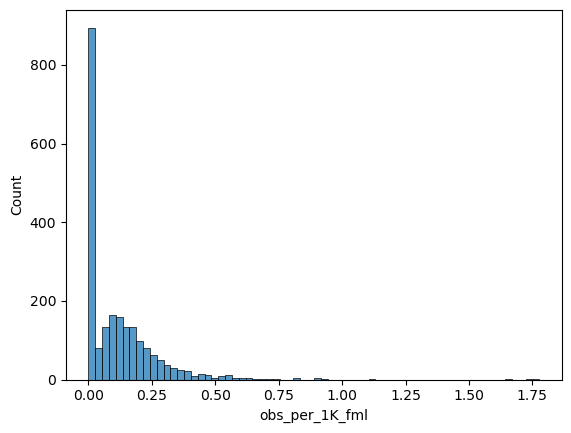

In [25]:
sns.histplot(data=df_metro, x='obs_per_1K_fml'); 

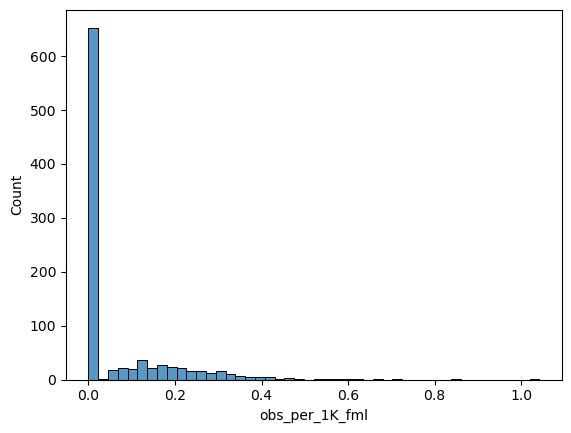

In [26]:
sns.histplot(data=df_rural, x='obs_per_1K_fml'); 

In [27]:
zero_obs_rural = df_rural[(df_rural['obs_per_1K_fml'] == 0)] #separate out the zeros
zero_obs_metro = df_metro[(df_metro['obs_per_1K_fml'] == 0)] #separate out the zeros

In [28]:
zero_obs = df_new[(df_new['obs_per_1K_fml'] == 0)]
zero_obs['obs_per_fml'].describe()

count    1531.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: obs_per_fml, dtype: float64

In [29]:
zero_obs_rural['obs_per_fml'].describe()
#653 counties with zero OBs still

count    653.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: obs_per_fml, dtype: float64

In [30]:
zero_obs_metro['obs_per_fml'].describe()
#878 metro counties with zero

count    878.0
mean       0.0
std        0.0
min        0.0
25%        0.0
50%        0.0
75%        0.0
max        0.0
Name: obs_per_fml, dtype: float64

#### Explore # of OBs per 1000 female population and segmented by state

In [31]:
df_new['obs_per_1K_fml'].describe()
# maximum number, 1.8 - still very low numbers for 75% or more of pop

count    3143.000000
mean        0.099950
std         0.144925
min         0.000000
25%         0.000000
50%         0.035569
75%         0.164526
max         1.777413
Name: obs_per_1K_fml, dtype: float64

In [32]:
# highest and lowest female populations
df_sorted_fmls = df_new.groupby('st_name')['popn_fem_21'].sum().sort_values()
df_sorted_fmls

st_name
Wyoming                282589.0
Vermont                324720.0
Alaska                 348469.0
Dist. of Columbia      351146.0
North Dakota           376539.0
South Dakota           440534.0
Delaware               516048.0
Montana                545001.0
Rhode Island           558649.0
Maine                  695754.0
New Hampshire          695860.0
Hawaii                 716220.0
West Virginia          893861.0
Idaho                  942307.0
Nebraska               976900.0
New Mexico            1063180.0
Kansas                1464091.0
Mississippi           1514629.0
Arkansas              1532713.0
Nevada                1559894.0
Iowa                  1591695.0
Utah                  1647906.0
Connecticut           1836010.0
Oklahoma              2002339.0
Oregon                2129317.0
Kentucky              2275505.0
Louisiana             2358856.0
Alabama               2591778.0
South Carolina        2666990.0
Minnesota             2846977.0
Colorado              2867419.0


In [33]:
#OBs per 1000 females, sorted
df_sorted_OBsperfml = df_new.groupby('st_name')['obs_per_1K_fml'].sum().sort_values()
df_sorted_OBsperfml

st_name
Delaware              0.560558
Dist. of Columbia     0.612281
Hawaii                0.943995
Rhode Island          1.566390
Arizona               1.739737
North Dakota          2.019926
Connecticut           2.065123
Alaska                2.194624
Nevada                2.244808
Utah                  2.354812
New Hampshire         2.450499
Idaho                 2.638394
Maine                 2.702433
New Mexico            3.049724
Nebraska              3.170039
Vermont               3.192134
Wyoming               3.396553
Massachusetts         3.434474
Washington            3.843707
Oklahoma              4.078053
Maryland              4.385931
New Jersey            4.564010
Kansas                4.642183
South Dakota          4.824999
Iowa                  4.895505
Arkansas              4.992567
Montana               4.998869
West Virginia         5.136198
Alabama               5.397552
South Carolina        5.697561
Oregon                6.203050
Wisconsin             7.133923


In [34]:
#What is the obgyn per 1k female number, segmented both by state and county?
obsperfml_sorted_stcntys = df_new.groupby(['st_name','cnty_name','popn_est_21'])['obs_per_1K_fml'].sum()
obsperfml_sorted_stcntys 
#seems to have some interesting outliers? patterns = higher pops, higher OBs, but what about places where that is not true? 
#e.g. Wyoming, in Teton vs Sweetwater rates vs population

st_name  cnty_name   popn_est_21
Alabama  Autauga     59095.0        0.000000
         Baldwin     239294.0       0.211602
         Barbour     24964.0        0.000000
         Bibb        22477.0        0.000000
         Blount      59041.0        0.000000
                                      ...   
Wyoming  Sweetwater  41614.0        0.199422
         Teton       23575.0        0.622388
         Uinta       20635.0        0.098951
         Washakie    7705.0         0.000000
         Weston      6745.0         0.000000
Name: obs_per_1K_fml, Length: 3143, dtype: float64

In [35]:
top_ten = df_new.nlargest(10, 'obs_per_1K_fml')
top_ten

,st_name,st_name_abbrev,cnty_name,cnty_name_st_abbrev,fips_st,fips_st_cnty,fips_cnty,cens_regn,cens_regn_name,cens_divsn,...,contgs_cnty_num10,contgs_cnty_num11,contgs_cnty_num12,contgs_cnty_num13,contgs_cnty_num14,obs_per_fml,obs_per_1K_fml,obs_per_birth,obs_per_11_births,peds_per_birth
2932,Virginia,VA,Falls Church City,"Falls Church City, VA",51,51610,610,3,South,5.0,...,NaN,NaN,NaN,NaN,NaN,0.001777,1.777413,0.070270,0.772973,0.097297
2295,Pennsylvania,PA,Montour,"Montour, PA",42,42093,93,1,Northeast,2.0,...,NaN,NaN,NaN,NaN,NaN,0.001740,1.739698,0.068670,0.755365,0.107296
2924,Virginia,VA,Charlottesville City,"Charlottesville City, VA",51,51540,540,3,South,5.0,...,NaN,NaN,NaN,NaN,NaN,0.001655,1.654927,0.065767,0.723440,0.111298
2934,Virginia,VA,Fredericksburg City,"Fredericksburg City, VA",51,51630,630,3,South,5.0,...,NaN,NaN,NaN,NaN,NaN,0.001120,1.120485,0.047887,0.526761,0.028169
2946,Virginia,VA,Norton City,"Norton City, VA",51,51720,720,3,South,5.0,...,NaN,NaN,NaN,NaN,NaN,0.001042,1.042209,0.044444,0.488889,0.044444
1153,Louisiana,LA,Orleans,"Orleans, LA",22,22071,71,3,South,7.0,...,NaN,NaN,NaN,NaN,NaN,0.000927,0.927018,0.041367,0.455036,0.045638
1863,New York,NY,New York,"New York, NY",36,36061,61,1,Northeast,2.0,...,NaN,NaN,NaN,NaN,NaN,0.000911,0.910860,0.048137,0.529502,0.055936
3004,West Virginia,WV,Cabell,"Cabell, WV",54,54011,11,3,South,5.0,...,NaN,NaN,NaN,NaN,NaN,0.000904,0.904007,0.043260,0.475855,0.041247
1316,Michigan,MI,Washtenaw,"Washtenaw, MI",26,26161,161,2,Midwest,3.0,...,NaN,NaN,NaN,NaN,NaN,0.000904,0.903872,0.049896,0.548857,0.065637
1962,North Carolina,NC,Orange,"Orange, NC",37,37135,135,3,South,5.0,...,NaN,NaN,NaN,NaN,NaN,0.000899,0.898773,0.064279,0.707071,0.107438


In [326]:
bottom_ten_df = df_new.nsmallest(10, 'obs_per_1K_fml')
bottom_ten_df

,st_name,st_name_abbrev,cnty_name,cnty_name_st_abbrev,fips_st,fips_st_cnty,fips_cnty,cens_regn,cens_regn_name,cens_divsn,...,noins_fem_18_64_19,noins_fem_18_64_pct_20,noins_fem_18_64_pct_19,stgh_birth_postprtm_rm_21,md_nf_ped_gen_21,obs_per_fml,obs_per_1K_fml,obs_per_birth,obs_per_11_births,peds_per_birth
0,Alabama,AL,Autauga,"Autauga, AL",1,1001,1,3,South,6.0,...,1814.0,12.0,10.4,0.0,1.0,0.0,0.0,0.0,0.0,0.001541
2,Alabama,AL,Barbour,"Barbour, AL",1,1005,5,3,South,6.0,...,953.0,17.0,15.2,0.0,1.0,0.0,0.0,0.0,0.0,0.003650
3,Alabama,AL,Bibb,"Bibb, AL",1,1007,7,3,South,6.0,...,788.0,14.5,12.8,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,Alabama,AL,Blount,"Blount, AL",1,1009,9,3,South,6.0,...,2696.0,15.4,16.0,0.0,2.0,0.0,0.0,0.0,0.0,0.003180
5,Alabama,AL,Bullock,"Bullock, AL",1,1011,11,3,South,6.0,...,337.0,14.0,13.0,0.0,1.0,0.0,0.0,0.0,0.0,0.007692
6,Alabama,AL,Butler,"Butler, AL",1,1013,13,3,South,6.0,...,845.0,14.8,14.2,0.0,1.0,0.0,0.0,0.0,0.0,0.004673
8,Alabama,AL,Chambers,"Chambers, AL",1,1017,17,3,South,6.0,...,1353.0,13.9,13.4,0.0,1.0,0.0,0.0,0.0,0.0,0.002809
9,Alabama,AL,Cherokee,"Cherokee, AL",1,1019,19,3,South,6.0,...,1042.0,13.6,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
10,Alabama,AL,Chilton,"Chilton, AL",1,1021,21,3,South,6.0,...,2029.0,17.6,15.5,0.0,1.0,0.0,0.0,0.0,0.0,0.001795
11,Alabama,AL,Choctaw,"Choctaw, AL",1,1023,23,3,South,6.0,...,481.0,12.6,12.8,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


### Create geodataframe for mapping / spatial analysis called gdf_new
Join CDs in df_new to geographic polygons for geodataframe analysis (gdf_new) using  congressional boundary files (gdf_cdistricts). Split rural/urban with gdf_rural, gdf_metro. Source of GeoDataframes for spatial analysis: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

In [196]:
#gdf_counties_new = gpd.read_file('/Users/annafeldman/Desktop/2020_Gaz_counties_national.csv')
gdf_counties_congress = gpd.read_file('/Users/annafeldman/Desktop/INFO696/Final Files/AHRF_CSVandDocu copy/county_congressdistricts_census/cb_2018_us_county_within_cd116_500k.shp')

In [200]:
gdf_counties_congress #shows county name and fips
#need to concatenate STATEFP and CD116FP for unique number: state_cd_num

,STATEFP,COUNTYFP,CD116FP,AFFGEOID,GEOID,PARTFLG,ALAND,geometry,LandArea_SqMiles
0,31,007,03,5101600US3103007,3103007,N,1932676689,"POLYGON ((-104.05294 41.63817, -104.05291 41.6...",746.210673
1,22,057,01,5101600US2201057,2201057,Y,1943718627,"MULTIPOLYGON (((-90.33541 29.06806, -90.32757 ...",750.473989
2,22,071,01,5101600US2201071,2201071,Y,27736769,"MULTIPOLYGON (((-90.12487 29.97630, -90.12466 ...",10.709227
3,22,103,01,5101600US2201103,2201103,N,2191719306,"POLYGON ((-90.25725 30.71158, -90.25565 30.711...",846.227591
4,22,053,03,5101600US2203053,2203053,N,1687025357,"POLYGON ((-93.13115 30.42361, -93.12584 30.423...",651.364160
...,...,...,...,...,...,...,...,...,...
3832,01,081,03,5101600US0103081,0103081,N,1573548952,"POLYGON ((-85.69675 32.69743, -85.69570 32.697...",607.550673
3833,37,181,01,5101600US3701181,3701181,N,653708021,"POLYGON ((-78.51122 36.45481, -78.50721 36.467...",252.398089
3834,55,103,03,5101600US5503103,5503103,Y,1313273316,"POLYGON ((-90.67165 43.55286, -90.65267 43.552...",507.057684
3835,22,007,02,5101600US2202007,2202007,Y,278235174,"POLYGON ((-91.15344 29.98439, -91.15151 29.986...",107.427206


In [201]:
gdf_counties_congress['CD116FP'].describe()
#need to concatenate STATEFP and CD116FP for unique number

count     3837
unique      55
top         01
freq       492
Name: CD116FP, dtype: object

In [202]:
#add square miles 
gdf_counties_congress['LandArea_SqMiles']= gdf_counties_congress['ALAND']/2589988
gdf_counties_congress.head()

,STATEFP,COUNTYFP,CD116FP,AFFGEOID,GEOID,PARTFLG,ALAND,geometry,LandArea_SqMiles
0,31,007,03,5101600US3103007,3103007,N,1932676689,"POLYGON ((-104.05294 41.63817, -104.05291 41.6...",746.210673
1,22,057,01,5101600US2201057,2201057,Y,1943718627,"MULTIPOLYGON (((-90.33541 29.06806, -90.32757 ...",750.473989
2,22,071,01,5101600US2201071,2201071,Y,27736769,"MULTIPOLYGON (((-90.12487 29.97630, -90.12466 ...",10.709227
3,22,103,01,5101600US2201103,2201103,N,2191719306,"POLYGON ((-90.25725 30.71158, -90.25565 30.711...",846.227591
4,22,053,03,5101600US2203053,2203053,N,1687025357,"POLYGON ((-93.13115 30.42361, -93.12584 30.423...",651.364160


In [203]:
move_cols = gdf_counties_congress.pop('LandArea_SqMiles')

# Insert the last column at the desired position (e.g., index 1)
gdf_counties_congress.insert(7, 'LandArea_SqMiles', move_cols)

# Check the new column order
print(gdf_counties_congress.columns)

Index(['STATEFP', 'COUNTYFP', 'CD116FP', 'AFFGEOID', 'GEOID', 'PARTFLG',
       'ALAND', 'LandArea_SqMiles', 'geometry'],
      dtype='object')


### Join gdf_counties_congress to df_new for gdf_cdistricts for all congressional districts (CDs)
#### Create new column concatenating state fips and county fips codes before joining to health data, create "state_cd_num" to create unique CD num
df_new already has a concatenated state-city variable to use for joining; gdf_cdistricts contains CD shapefile data; df dataframe contains FIPS state and county codes

In [205]:
gdf_counties_congress['state_cty_fips'] = gdf_counties_congress['STATEFP'] + gdf_counties_congress['COUNTYFP']
gdf_counties_congress['state_cd_num'] = gdf_counties_congress['STATEFP'] + gdf_counties_congress['CD116FP']

move_cols2 = gdf_counties_congress.pop('state_cty_fips')
gdf_counties_congress.insert(7, 'state_cty_fips', move_cols2)

gdf_counties_congress.head()
#gdf_counties_congress.info() #3837 entries

,STATEFP,COUNTYFP,CD116FP,AFFGEOID,GEOID,PARTFLG,ALAND,state_cty_fips,LandArea_SqMiles,geometry,state_cd_num
0,31,007,03,5101600US3103007,3103007,N,1932676689,31007,746.210673,"POLYGON ((-104.05294 41.63817, -104.05291 41.6...",3103
1,22,057,01,5101600US2201057,2201057,Y,1943718627,22057,750.473989,"MULTIPOLYGON (((-90.33541 29.06806, -90.32757 ...",2201
2,22,071,01,5101600US2201071,2201071,Y,27736769,22071,10.709227,"MULTIPOLYGON (((-90.12487 29.97630, -90.12466 ...",2201
3,22,103,01,5101600US2201103,2201103,N,2191719306,22103,846.227591,"POLYGON ((-90.25725 30.71158, -90.25565 30.711...",2201
4,22,053,03,5101600US2203053,2203053,N,1687025357,22053,651.364160,"POLYGON ((-93.13115 30.42361, -93.12584 30.423...",2203


In [206]:
#df_new['fips_st_cnty'].head()
df_new.head()

,st_name,st_name_abbrev,cnty_name,cnty_name_st_abbrev,fips_st,fips_st_cnty,fips_cnty,cens_regn,cens_regn_name,cens_divsn,...,noins_fem_18_64_19,noins_fem_18_64_pct_20,noins_fem_18_64_pct_19,stgh_birth_postprtm_rm_21,md_nf_ped_gen_21,obs_per_fml,obs_per_1K_fml,obs_per_birth,obs_per_11_births,peds_per_birth
0,Alabama,AL,Autauga,"Autauga, AL",1,1001,1,3,South,6.0,...,1814.0,12.0,10.4,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.001541
1,Alabama,AL,Baldwin,"Baldwin, AL",1,1003,3,3,South,6.0,...,8084.0,11.8,12.2,3.0,26.0,0.000212,0.211602,0.011504,0.126549,0.011504
2,Alabama,AL,Barbour,"Barbour, AL",1,1005,5,3,South,6.0,...,953.0,17.0,15.2,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.003650
3,Alabama,AL,Bibb,"Bibb, AL",1,1007,7,3,South,6.0,...,788.0,14.5,12.8,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,Alabama,AL,Blount,"Blount, AL",1,1009,9,3,South,6.0,...,2696.0,15.4,16.0,0.0,2.0,0.000000,0.000000,0.000000,0.000000,0.003180


In [207]:
gdf_counties_congress['state_cty_fips'].dtype #object
df_new['fips_st_cnty'].dtype #int

dtype('int64')

In [208]:
# Convert new col in gdf_counties to integer
gdf_counties_congress['state_cty_fips'] = gdf_counties_congress['state_cty_fips'].astype(int)
gdf_counties_congress['state_cty_fips'].dtype

dtype('int64')

In [209]:
# Merge gdf and df based on FIPS state and county code variable
gdf_new_cd = gpd.GeoDataFrame(pd.merge(gdf_counties_congress, df_new, how='inner', 
                                      right_on=['fips_st_cnty'], left_on=['state_cty_fips']))
gdf_new_cd.head()

,STATEFP,COUNTYFP,CD116FP,AFFGEOID,GEOID,PARTFLG,ALAND,state_cty_fips,LandArea_SqMiles,geometry,...,noins_fem_18_64_19,noins_fem_18_64_pct_20,noins_fem_18_64_pct_19,stgh_birth_postprtm_rm_21,md_nf_ped_gen_21,obs_per_fml,obs_per_1K_fml,obs_per_birth,obs_per_11_births,peds_per_birth
0,31,007,03,5101600US3103007,3103007,N,1932676689,31007,746.210673,"POLYGON ((-104.05294 41.63817, -104.05291 41.6...",...,11.0,6.3,5.4,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,22,057,01,5101600US2201057,2201057,Y,1943718627,22057,750.473989,"MULTIPOLYGON (((-90.33541 29.06806, -90.32757 ...",...,3700.0,11.6,12.5,2.0,9.0,0.000324,0.323710,0.014679,0.161468,0.008257
2,22,071,01,5101600US2201071,2201071,Y,27736769,22071,10.709227,"MULTIPOLYGON (((-90.12487 29.97630, -90.12466 ...",...,10955.0,8.2,8.5,2.0,203.0,0.000927,0.927018,0.041367,0.455036,0.045638
3,22,103,01,5101600US2201103,2201103,N,2191719306,22103,846.227591,"POLYGON ((-90.25725 30.71158, -90.25565 30.711...",...,7166.0,8.3,9.1,2.0,71.0,0.000283,0.282959,0.014466,0.159125,0.026335
4,22,053,03,5101600US2203053,2203053,N,1687025357,22053,651.364160,"POLYGON ((-93.13115 30.42361, -93.12584 30.423...",...,927.0,11.0,10.1,1.0,1.0,0.000183,0.182960,0.007389,0.081281,0.002463


In [210]:
#df_new.info()
#gdf_cdistricts.info()
gdf_new_cd.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3745 entries, 0 to 3744
Columns: 111 entries, STATEFP to peds_per_birth
dtypes: float64(89), geometry(1), int64(7), object(14)
memory usage: 3.2+ MB


In [211]:
#remove duplicate rows based on all columns
gdf_new_cd = gdf_new_cd.drop_duplicates()
#df_new.reset_index(drop=True, inplace=True)

In [212]:
#remove duplicate rows based on all columns
gdf_new_cd['state_cd_num'].describe()
#df_new.reset_index(drop=True, inplace=True)

count     3745
unique     436
top       3103
freq        75
Name: state_cd_num, dtype: object

In [213]:
gdf_new_cd['state_cd_num'].astype(int)

0       3103
1       2201
2       2201
3       2201
4       2203
        ... 
3740     103
3741    3701
3742    5503
3743    2202
3744    1801
Name: state_cd_num, Length: 3745, dtype: int64

### Dissolve counties into congressional district (CD) polygons
Join to df, then aggregate variables from above

In [214]:
# Fix invalid geometries if any
#gdf_new_cd['geometry'] = gdf_new_cd['geometry'].buffer(0)
#gdf_new_cd = gdf_new_cd.to_crs("EPSG:4326")
gdf_new_cd.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

#### Aggregate variables by CD (OBs per female, per 1000 females, per birth / Pediatricians per birth)

In [247]:
# dissolve counties into congressional districts (CD116FP)
# sum only specific variables
# Create aggregation dictionary for columns to sum
agg_dict = {
    'obs_per_fml': 'sum',
    'obs_per_birth': 'sum',
    'peds_per_birth': 'sum',
    'popn_fem_21': 'sum',
    'md_nf_obgyn_gen_21': 'sum',    
    'popn_21': 'sum',          
    'state_cd_num':'first',
    'CD116FP': 'first',
    'st_name_abbrev':'first'
}

# dissolve with the specified aggregation function
gdf_cdistricts = gdf_new_cd.dissolve(by='state_cd_num', aggfunc=agg_dict)

# reset index
gdf_cdistricts = gdf_cdistricts.reset_index(drop=True)

gdf_cdistricts['obs_per1Kfml_cd'] = gdf_cdistricts['obs_per_fml'] * 1000

In [248]:
#old
#gdf_cdistricts = gdf_new_cd.dissolve(by='state_cd_num', as_index=False)
gdf_cdistricts.head()

,geometry,obs_per_fml,obs_per_birth,peds_per_birth,popn_fem_21,md_nf_obgyn_gen_21,popn_21,state_cd_num,CD116FP,st_name_abbrev,obs_per1Kfml_cd
0,"MULTIPOLYGON (((-88.29971 30.23181, -88.27915 ...",0.000651,0.030140,0.028824,386843.0,99.0,746621.0,0101,01,AL,0.650583
1,"POLYGON ((-86.23833 30.99437, -86.25645 30.993...",0.000903,0.037865,0.090363,402557.0,52.0,780061.0,0102,02,AL,0.903337
2,"POLYGON ((-86.19849 32.39290, -86.19599 32.393...",0.000956,0.046577,0.057685,477166.0,59.0,924355.0,0103,03,AL,0.955710
3,"POLYGON ((-87.26052 33.50367, -87.26136 33.500...",0.001381,0.062867,0.093807,507339.0,62.0,996646.0,0104,04,AL,1.381159
4,"POLYGON ((-87.10937 34.41581, -87.10817 34.459...",0.000783,0.039320,0.046324,391515.0,72.0,773212.0,0105,05,AL,0.783297


In [249]:
#df_new.info()
#gdf_cdistricts.info()
gdf_cdistricts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   geometry            436 non-null    geometry
 1   obs_per_fml         436 non-null    float64 
 2   obs_per_birth       436 non-null    float64 
 3   peds_per_birth      436 non-null    float64 
 4   popn_fem_21         436 non-null    float64 
 5   md_nf_obgyn_gen_21  436 non-null    float64 
 6   popn_21             436 non-null    float64 
 7   state_cd_num        436 non-null    object  
 8   CD116FP             436 non-null    object  
 9   st_name_abbrev      436 non-null    object  
 10  obs_per1Kfml_cd     436 non-null    float64 
dtypes: float64(7), geometry(1), object(3)
memory usage: 37.6+ KB


In [250]:
print(gdf_cdistricts.crs)

EPSG:4269


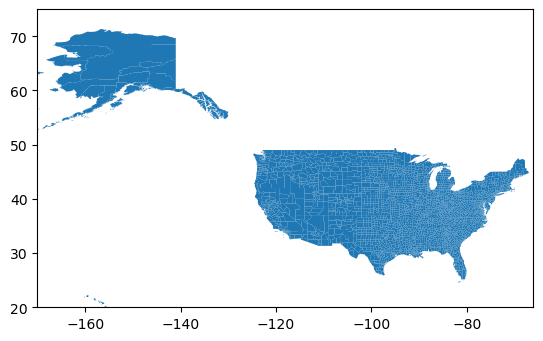

In [252]:
#Plot the original counties gdf
gdf_counties_congress.plot()
#set axis limits (x_min, x_max, y_min, y_max)
plt.xlim(-170, -66)
plt.ylim(20, 75)

plt.show()

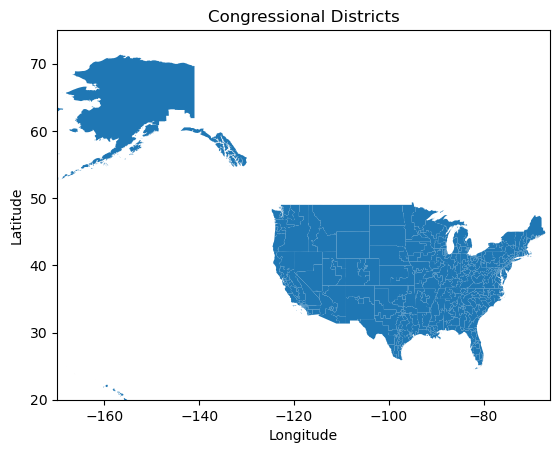

In [253]:
# Plot the congressional districts
gdf_cdistricts.plot()

# Add title and labels
plt.title('Congressional Districts')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(-170, -66)
plt.ylim(20, 75)
# Show the plot
plt.show()

### EDA: Top ten CDs by OBGYN numbers per female, per birth, peds per birth

In [282]:
#Top ten OBs per 1000 females in population?
top_ten_ob = gdf_cdistricts.nlargest(10, 'obs_per1Kfml_cd')
top_ten_ob[['state_cd_num','st_name_abbrev','obs_per1Kfml_cd']]

,state_cd_num,st_name_abbrev,obs_per1Kfml_cd
233,3000,MT,4.998869
352,4600,SD,4.824999
76,0803,CO,4.181687
407,5105,VA,3.538302
435,5600,WY,3.396553
213,2701,MN,3.367476
199,2601,MI,3.295324
402,5000,VT,3.192134
411,5109,VA,3.099097
116,1302,GA,3.093984


In [281]:
top_ten_peds = gdf_cdistricts.nlargest(10, 'peds_per_birth')
top_ten_peds[['state_cd_num','st_name_abbrev','peds_per_birth']]

,state_cd_num,st_name_abbrev,peds_per_birth
402,5000,VT,0.359084
407,5105,VA,0.286107
233,3000,MT,0.275115
411,5109,VA,0.268460
164,2001,KS,0.254787
199,2601,MI,0.230487
433,5507,WI,0.217579
257,3503,NM,0.206984
352,4600,SD,0.204222
343,4401,RI,0.199449


In [280]:
top_ten_ob_births = gdf_cdistricts.nlargest(10, 'obs_per_birth')
top_ten_ob_births[['state_cd_num','st_name_abbrev', 'obs_per_birth']]

,state_cd_num,st_name_abbrev,obs_per_birth
233,3000,MT,0.277888
76,0803,CO,0.264673
352,4600,SD,0.208261
402,5000,VT,0.206310
199,2601,MI,0.201848
407,5105,VA,0.182874
411,5109,VA,0.177409
213,2701,MN,0.158853
321,4102,OR,0.158327
435,5600,WY,0.157903


In [279]:
#Lowest ten OBs per 1000 females in population?
btm_ten_ob = gdf_cdistricts.nsmallest(10, 'obs_per1Kfml_cd')

# Display the result
btm_ten_ob[['state_cd_num','st_name_abbrev','obs_per1Kfml_cd']]

,state_cd_num,st_name_abbrev,obs_per1Kfml_cd
56,0636,CA,0.115227
61,0641,CA,0.115227
62,0642,CA,0.115227
51,0631,CA,0.144134
272,3615,NY,0.169507
237,3201,NV,0.187820
239,3203,NV,0.187820
263,3606,NY,0.192112
100,1213,FL,0.224408
12,0405,AZ,0.226392


In [278]:
btm_ten_ob_births = gdf_cdistricts.nsmallest(10, 'obs_per_birth')
btm_ten_ob_births[['state_cd_num','st_name_abbrev', 'obs_per_birth']]

,state_cd_num,st_name_abbrev,obs_per_birth
56,0636,CA,0.005201
61,0641,CA,0.005201
62,0642,CA,0.005201
51,0631,CA,0.005814
272,3615,NY,0.006980
237,3201,NV,0.008435
239,3203,NV,0.008435
263,3606,NY,0.008984
266,3609,NY,0.009136
377,4816,TX,0.009285


In [277]:
btm_ten_peds = gdf_cdistricts.nsmallest(10, 'peds_per_birth')
btm_ten_peds[['state_cd_num','st_name_abbrev', 'peds_per_birth']]

,state_cd_num,st_name_abbrev,peds_per_birth
56,0636,CA,0.007119
61,0641,CA,0.007119
62,0642,CA,0.007119
237,3201,NV,0.008592
239,3203,NV,0.008592
211,2613,MI,0.010759
51,0631,CA,0.011038
240,3204,NV,0.011163
377,4816,TX,0.013017
391,4830,TX,0.013198


#### CDs with zero OBGYNs available

In [260]:
zero_obs_gdf = gdf_cdistricts[(gdf_cdistricts['obs_per1Kfml_cd'] == 0)] 

In [261]:
zero_obs_gdf['obs_per1Kfml_cd'].describe() #no CDs with zero Obs

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: obs_per1Kfml_cd, dtype: float64

### Analysis: Mapping metrics by congressional district instead of county
Test maps by new variables, then create score for combining OBGYNs per 1K females, OBGYNs per birth, and Pediatricians per birth


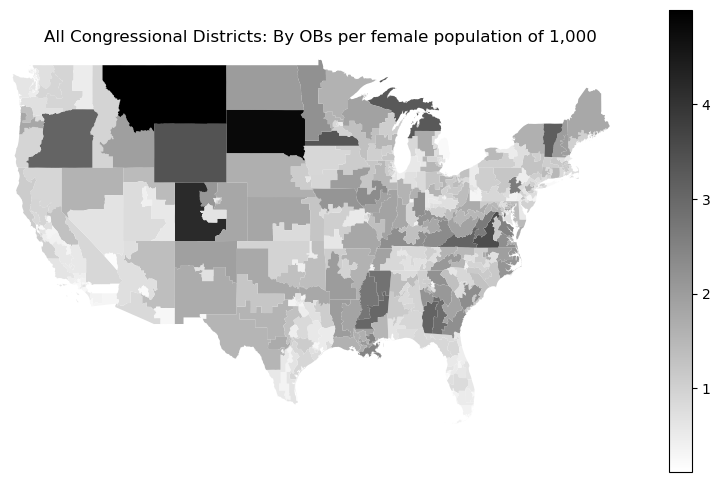

In [262]:
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed
gdf_cdistricts.plot(column='obs_per1Kfml_cd', cmap='binary', ax=ax, legend=True)

# Add title and labels
plt.title('All Congressional Districts: By OBs per female population of 1,000')

#set axis limits (x_min, x_max, y_min, y_max)
plt.xlim(-125, -65)
plt.ylim(24, 50)
ax.axis('off')

plt.show()

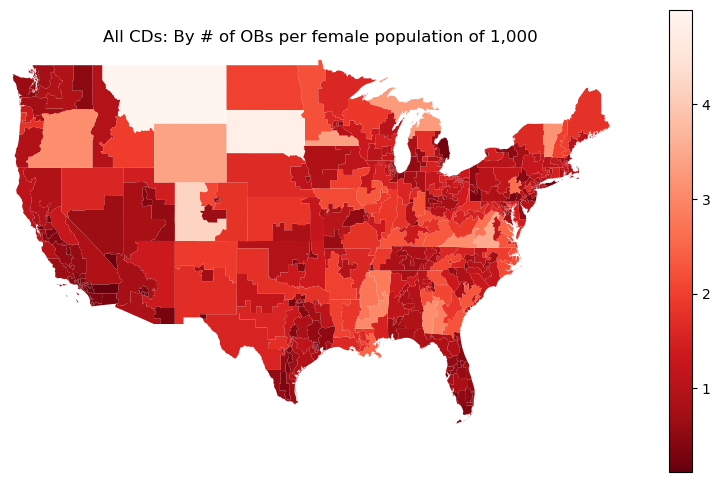

In [263]:
#try different symoboloy / color scheme for choropleth
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed
gdf_cdistricts.plot(column='obs_per1Kfml_cd', cmap='Reds_r', ax=ax, legend=True)

# Add title and labels
plt.title('All CDs: By # of OBs per female population of 1,000')

#set axis limits (x_min, x_max, y_min, y_max)
plt.xlim(-125, -65)
plt.ylim(24, 50)
ax.axis('off')

plt.show();

### Create scoring then map again
Check descriptive statistics for each variable: OBGYNs per 1K females, OBGYNs per birth, and Pediatricians per birth. OBGYNs per 1K females: ave = 1.04 median = .85 | OBGYNs per birth: ave = .05 median = .04 | Pediatricians per birth: ave = .07 median = .06

In [264]:
gdf_cdistricts['obs_per1Kfml_cd'].describe()

count    436.000000
mean       1.041043
std        0.733717
min        0.115227
25%        0.524557
50%        0.853942
75%        1.354442
max        4.998869
Name: obs_per1Kfml_cd, dtype: float64

In [265]:
gdf_cdistricts['obs_per_birth'].describe()

count    436.000000
mean       0.051226
std        0.037977
min        0.005201
25%        0.024688
50%        0.041973
75%        0.067124
max        0.277888
Name: obs_per_birth, dtype: float64

In [266]:
gdf_cdistricts['peds_per_birth'].describe()

count    436.000000
mean       0.073277
std        0.050081
min        0.007119
25%        0.037151
50%        0.062302
75%        0.096523
max        0.359084
Name: peds_per_birth, dtype: float64

#### scoring logic 
Score of 1 to 4, with all metrics above average = 4, all metrics below average = 1. Those in between are either 2 (if 2/3 of the metrics are below ave) or 3 (if 1/3 of the metrics are below ave).

In [267]:
#OBGYNs per 1K females: ave = 1.04 median = .85 | 
#OBGYNs per birth: ave = .05 median = .04 | 
#Pediatricians per birth: ave = .07 median = .06

# if all metrics above average, set score = 4
# if 'obs_per1Kfml_cd' is above ave of 1.04 and 'obs_per_birth' is above ave of .05 
# and 'peds_per_birth' is above ave of .07, score = 3

# if all metrics below average, score = 1
# if 'obs_per1Kfml_cd' is below ave of 1.04 and 'obs_per_birth' is below ave of .05 
# and 'peds_per_birth' is below ave of .07, score = 1

# if 'obs_per1Kfml_cd' is below ave of 1.04 and 'obs_per_birth' is above ave of .05 
# and 'peds_per_birth' is above ave of .07, score = 3

# if 'obs_per1Kfml_cd' is above ave of 1.04 and 'obs_per_birth' is below ave of .05 
# and 'peds_per_birth' is above ave of .07, score = 3

# if 'obs_per1Kfml_cd' is above ave of 1.04 and 'obs_per_birth' is above ave of .05 
# and 'peds_per_birth' is below ave of .07, score = 3

# if 'obs_per1Kfml_cd' is above ave of 1.04 and 'obs_per_birth' is below ave of .05 
# and 'peds_per_birth' is below ave of .07, score = 2

# if 'obs_per1Kfml_cd' is below ave of 1.04 and 'obs_per_birth' is above ave of .05 
# and 'peds_per_birth' is below ave of .07, score = 2

# if 'obs_per1Kfml_cd' is below ave of 1.04 and 'obs_per_birth' is below ave of .05 
# and 'peds_per_birth' is above ave of .07, score = 2


In [283]:
# Define conditions for each case
conditions = [
    (gdf_cdistricts['obs_per1Kfml_cd'] > 1.04) & (gdf_cdistricts['obs_per_birth'] > 0.05) & (gdf_cdistricts['peds_per_birth'] > 0.07),  # all metrics above average
    (gdf_cdistricts['obs_per1Kfml_cd'] < 1.04) & (gdf_cdistricts['obs_per_birth'] < 0.05) & (gdf_cdistricts['peds_per_birth'] < 0.07),  # all metrics below average
    (gdf_cdistricts['obs_per1Kfml_cd'] < 1.04) & (gdf_cdistricts['obs_per_birth'] > 0.05) & (gdf_cdistricts['peds_per_birth'] > 0.07),  # mixed conditions
    (gdf_cdistricts['obs_per1Kfml_cd'] > 1.04) & (gdf_cdistricts['obs_per_birth'] < 0.05) & (gdf_cdistricts['peds_per_birth'] > 0.07),
    (gdf_cdistricts['obs_per1Kfml_cd'] > 1.04) & (gdf_cdistricts['obs_per_birth'] > 0.05) & (gdf_cdistricts['peds_per_birth'] < 0.07),
    (gdf_cdistricts['obs_per1Kfml_cd'] > 1.04) & (gdf_cdistricts['obs_per_birth'] < 0.05) & (gdf_cdistricts['peds_per_birth'] < 0.07),
    (gdf_cdistricts['obs_per1Kfml_cd'] < 1.04) & (gdf_cdistricts['obs_per_birth'] > 0.05) & (gdf_cdistricts['peds_per_birth'] < 0.07),
    (gdf_cdistricts['obs_per1Kfml_cd'] < 1.04) & (gdf_cdistricts['obs_per_birth'] < 0.05) & (gdf_cdistricts['peds_per_birth'] > 0.07)
]

# Define corresponding scores
scores = [4, 1, 3, 3, 3, 2, 2, 2]

# Assign scores based on conditions
gdf_cdistricts['score'] = np.select(conditions, scores, default=np.nan)  # default=np.nan for any unmatched conditions

# Print the dataframe with the new 'score' column
gdf_cdistricts[['state_cd_num','obs_per1Kfml_cd', 'obs_per_birth', 'peds_per_birth', 'score']].head(20)

,state_cd_num,obs_per1Kfml_cd,obs_per_birth,peds_per_birth,score
0,0101,0.650583,0.030140,0.028824,1.0
1,0102,0.903337,0.037865,0.090363,2.0
2,0103,0.955710,0.046577,0.057685,1.0
3,0104,1.381159,0.062867,0.093807,4.0
4,0105,0.783297,0.039320,0.046324,1.0
5,0106,0.833218,0.043748,0.057415,1.0
6,0107,1.136419,0.050175,0.070144,4.0
7,0200,2.194624,0.097181,0.134133,4.0
8,0401,1.364261,0.070446,0.096567,4.0
9,0402,0.280748,0.014849,0.038162,1.0


#### map again with scores

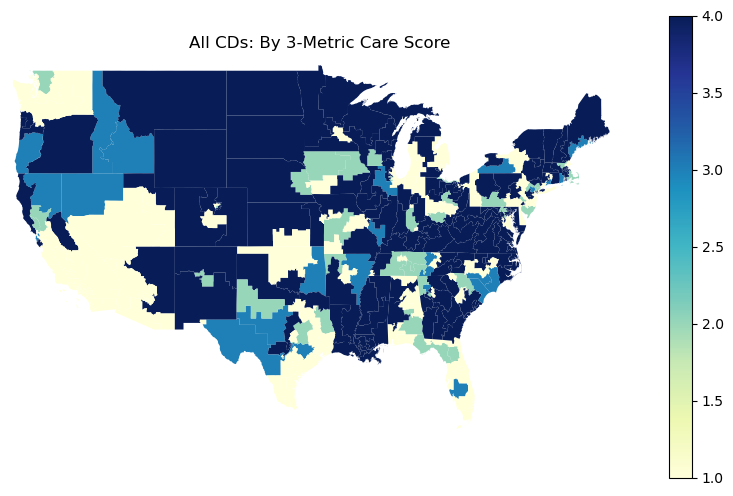

In [284]:
#try different symoboloy / color scheme for choropleth
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize as needed
gdf_cdistricts.plot(column='score', cmap='YlGnBu', ax=ax, legend=True)

# Add title and labels
plt.title('All CDs: By 3-Metric Care Score')

#set axis limits (x_min, x_max, y_min, y_max)
plt.xlim(-125, -65)
plt.ylim(24, 50)
ax.axis('off')

plt.show();

### Join to legislator files: Congress and Senate dfs

In [285]:
url2="/Users/annafeldman/Desktop/INFO696/Final Files/Final Project/legislators-current.csv"
df_leg = pd.read_csv(url2, encoding='latin-1')
df_leg[['last_name', 'first_name','full_name', 'birthday', 'gender', 'type', 'state', 'district','senate_class', 'party']].head(20)

,last_name,first_name,full_name,birthday,gender,type,state,district,senate_class,party
0,Brown,Sherrod,Sherrod Brown,1952-11-09,M,sen,OH,NaN,1.0,Democrat
1,Cantwell,Maria,Maria Cantwell,1958-10-13,F,sen,WA,NaN,1.0,Democrat
2,Cardin,Benjamin,Benjamin L. Cardin,1943-10-05,M,sen,MD,NaN,1.0,Democrat
3,Carper,Thomas,Thomas R. Carper,1947-01-23,M,sen,DE,NaN,1.0,Democrat
4,Casey,Robert,"Robert P. Casey, Jr.",1960-04-13,M,sen,PA,NaN,1.0,Democrat
5,Klobuchar,Amy,Amy Klobuchar,1960-05-25,F,sen,MN,NaN,1.0,Democrat
6,Menendez,Robert,Robert Menendez,1954-01-01,M,sen,NJ,NaN,1.0,Democrat
7,Sanders,Bernard,Bernard Sanders,1941-09-08,M,sen,VT,NaN,1.0,Independent
8,Stabenow,Debbie,Debbie Stabenow,1950-04-29,F,sen,MI,NaN,1.0,Democrat
9,Tester,Jon,Jon Tester,1956-08-21,M,sen,MT,NaN,1.0,Democrat


In [286]:
df_leg.columns

Index(['last_name', 'first_name', 'middle_name', 'suffix', 'nickname',
       'full_name', 'birthday', 'gender', 'type', 'state', 'district',
       'senate_class', 'party', 'url', 'address', 'phone', 'contact_form',
       'rss_url', 'twitter', 'twitter_id', 'facebook', 'youtube', 'youtube_id',
       'mastodon', 'bioguide_id', 'thomas_id', 'opensecrets_id', 'lis_id',
       'fec_ids', 'cspan_id', 'govtrack_id', 'votesmart_id', 'ballotpedia_id',
       'washington_post_id', 'icpsr_id', 'wikipedia_id'],
      dtype='object')

In [287]:
df_reps = df_leg.dropna(subset=['district'])
df_reps.info() #438 representatives
df_reps[['last_name', 'first_name','full_name', 'birthday', 'gender', 'type', 'state', 'district','senate_class', 'party']].head()

<class 'pandas.core.frame.DataFrame'>
Index: 438 entries, 26 to 537
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   last_name           438 non-null    object 
 1   first_name          438 non-null    object 
 2   middle_name         225 non-null    object 
 3   suffix              16 non-null     object 
 4   nickname            22 non-null     object 
 5   full_name           438 non-null    object 
 6   birthday            438 non-null    object 
 7   gender              438 non-null    object 
 8   type                438 non-null    object 
 9   state               438 non-null    object 
 10  district            438 non-null    float64
 11  senate_class        0 non-null      float64
 12  party               438 non-null    object 
 13  url                 438 non-null    object 
 14  address             438 non-null    object 
 15  phone               438 non-null    object 
 16  contact_form

,last_name,first_name,full_name,birthday,gender,type,state,district,senate_class,party
26,Aderholt,Robert,Robert B. Aderholt,1965-07-22,M,rep,AL,4.0,NaN,Republican
29,Bilirakis,Gus,Gus M. Bilirakis,1963-02-08,M,rep,FL,12.0,NaN,Republican
30,Bishop,Sanford,"Sanford D. Bishop, Jr.",1947-02-04,M,rep,GA,2.0,NaN,Democrat
32,Blumenauer,Earl,Earl Blumenauer,1948-08-16,M,rep,OR,3.0,NaN,Democrat
35,Buchanan,Vern,Vern Buchanan,1951-05-08,M,rep,FL,16.0,NaN,Republican


In [288]:
df_sens = df_leg.dropna(subset=['senate_class'])
df_sens.info() #100 senators
df_sens[['last_name', 'first_name','full_name', 'birthday', 'gender', 'type', 'state', 'district','senate_class', 'party']].head()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 530
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   last_name           100 non-null    object 
 1   first_name          100 non-null    object 
 2   middle_name         44 non-null     object 
 3   suffix              3 non-null      object 
 4   nickname            12 non-null     object 
 5   full_name           100 non-null    object 
 6   birthday            100 non-null    object 
 7   gender              100 non-null    object 
 8   type                100 non-null    object 
 9   state               100 non-null    object 
 10  district            0 non-null      float64
 11  senate_class        100 non-null    float64
 12  party               100 non-null    object 
 13  url                 100 non-null    object 
 14  address             100 non-null    object 
 15  phone               100 non-null    object 
 16  contact_form 

,last_name,first_name,full_name,birthday,gender,type,state,district,senate_class,party
0,Brown,Sherrod,Sherrod Brown,1952-11-09,M,sen,OH,NaN,1.0,Democrat
1,Cantwell,Maria,Maria Cantwell,1958-10-13,F,sen,WA,NaN,1.0,Democrat
2,Cardin,Benjamin,Benjamin L. Cardin,1943-10-05,M,sen,MD,NaN,1.0,Democrat
3,Carper,Thomas,Thomas R. Carper,1947-01-23,M,sen,DE,NaN,1.0,Democrat
4,Casey,Robert,"Robert P. Casey, Jr.",1960-04-13,M,sen,PA,NaN,1.0,Democrat


In [292]:
#create new column without leading zeros as float to match in join
gdf_cdistricts['state_cd_num'] = gdf_cdistricts['state_cd_num'].astype('float64')
gdf_cdistricts['CD116FP'] = gdf_cdistricts['CD116FP'].astype('float64')

In [293]:
gdf_cdistricts.head()

,geometry,obs_per_fml,obs_per_birth,peds_per_birth,popn_fem_21,md_nf_obgyn_gen_21,popn_21,state_cd_num,CD116FP,st_name_abbrev,obs_per1Kfml_cd,score
0,"MULTIPOLYGON (((-88.29971 30.23181, -88.27915 ...",0.000651,0.030140,0.028824,386843.0,99.0,746621.0,101.0,1.0,AL,0.650583,1.0
1,"POLYGON ((-86.23833 30.99437, -86.25645 30.993...",0.000903,0.037865,0.090363,402557.0,52.0,780061.0,102.0,2.0,AL,0.903337,2.0
2,"POLYGON ((-86.19849 32.39290, -86.19599 32.393...",0.000956,0.046577,0.057685,477166.0,59.0,924355.0,103.0,3.0,AL,0.955710,1.0
3,"POLYGON ((-87.26052 33.50367, -87.26136 33.500...",0.001381,0.062867,0.093807,507339.0,62.0,996646.0,104.0,4.0,AL,1.381159,4.0
4,"POLYGON ((-87.10937 34.41581, -87.10817 34.459...",0.000783,0.039320,0.046324,391515.0,72.0,773212.0,105.0,5.0,AL,0.783297,1.0


#### Create new Congress gdf (tbd Senate gdf)
Merge based on state string and CD number (float)

In [ ]:
# Assuming df1 and df2 are the two DataFrames to join
# Condition 1: String match (e.g., 'column_string')
# Condition 2: Float match (e.g., 'column_float')

# Perform the join based on both conditions
merged_df = pd.merge(df1, df2, how='inner', left_on=['st_name_abbrev', 'column_float'], right_on=['column_string', 'column_float'])

# If you want to handle potential precision issues with float comparison, you can add a tolerance check:
tolerance = 1e-6  # Define a tolerance for float comparison

# Create a helper column that checks if the float columns match within the tolerance
df1['float_match'] = df1['column_float'].round(6)
df2['float_match'] = df2['column_float'].round(6)

# Perform the join with the helper float column
merged_df = pd.merge(df1, df2, how='inner', left_on=['column_string', 'float_match'], right_on=['column_string', 'float_match'])

# Drop the helper column after merging if needed
merged_df.drop(columns=['float_match'], inplace=True)


In [ ]:
# Perform the join
merged_df = pd.merge(df1, df2, how='inner', left_on=['column_string', 'column_float'], right_on=['column_string', 'column_float'])

# Identify dropped rows from df1
dropped_rows_df1 = df1[~df1.index.isin(merged_df.index)]

# Alternatively, if there are potential index mismatches, use a left join and check for NaN values in df2 columns
left_merged_df = pd.merge(df1, df2, how='left', left_on=['column_string', 'column_float'], right_on=['column_string', 'column_float'])

# Dropped rows are those where the columns from df2 are NaN
dropped_rows_df1 = left_merged_df[left_merged_df[df2.columns].isna().any(axis=1)]

# View dropped rows
print(dropped_rows_df1)


In [319]:
# Merge gdf and df based on FIPS state and county code variable
gdf_c_reps = gpd.GeoDataFrame(pd.merge(gdf_cdistricts, df_reps, how='left', 
                                      right_on=['state','district'], left_on=['st_abbrv','CD116FP']))

In [321]:
#gdf_c_reps.head(20)
gdf_c_reps[['state','district','st_abbrv','CD116FP','last_name', 'first_name']].head()

,state,district,st_abbrv,CD116FP,last_name,first_name
0,AL,1.0,AL,1.0,Carl,Jerry
1,AL,2.0,AL,2.0,Moore,Barry
2,AL,3.0,AL,3.0,Rogers,Mike
3,AL,4.0,AL,4.0,Aderholt,Robert
4,AL,5.0,AL,5.0,Strong,Dale


In [322]:
gdf_c_reps.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 436 entries, 0 to 435
Data columns (total 43 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   geometry            436 non-null    geometry
 1   CD116FP             436 non-null    float64 
 2   ob_p_1Kfmls         436 non-null    float64 
 3   obs_brths           436 non-null    float64 
 4   peds_p_brth         436 non-null    float64 
 5   score               436 non-null    float64 
 6   st_abbrv            436 non-null    object  
 7   last_name           424 non-null    object  
 8   first_name          424 non-null    object  
 9   middle_name         213 non-null    object  
 10  suffix              15 non-null     object  
 11  nickname            22 non-null     object  
 12  full_name           424 non-null    object  
 13  birthday            424 non-null    object  
 14  gender              424 non-null    object  
 15  type                424 non-null

#### Delete: Create new columns to store reps for same CD in one row

In [163]:
# need to make all reps for same district go in the same row instead of creating multiple rows for each CD

# Create a new column that differentiates reps in the same congressional district
gdf_c_reps['rep_num'] = gdf_c_reps.groupby('CD116FP').cumcount() + 1

# Pivot the DataFrame
gdf_pivot = gdf_c_reps.pivot(index='CD116FP', columns='rep_num', values=['full_name'])
# to do, concatenate with party affil

# Flatten the MultiIndex columns
gdf_pivot.columns = [f'{col[0]}_{col[1]}' for col in gdf_pivot.columns]

# Reset the index
gdf_pivot = gdf_pivot.reset_index()

print(gdf_pivot)


    CD116FP               full_name_1                     full_name_2  \
0       0.0     Eleanor Holmes Norton  Gregorio Kilili Camacho Sablan   
1       1.0   Eric A. "Rick" Crawford                   Diana DeGette   
2       2.0    Sanford D. Bishop, Jr.                    Joe Courtney   
3       3.0           Earl Blumenauer                 Rosa L. DeLauro   
4       4.0        Robert B. Aderholt                        Tom Cole   
5       5.0           Emanuel Cleaver                   Virginia Foxx   
6       6.0          James E. Clyburn                      Sam Graves   
7       7.0             AndrÃ© Carson                  Danny K. Davis   
8       8.0             Larry Bucshon                  John Garamendi   
9       9.0          Yvette D. Clarke                     Steve Cohen   
10     10.0         Michael T. McCaul              Patrick T. McHenry   
11     11.0        Gerald E. Connolly                    Nancy Pelosi   
12     12.0          Gus M. Bilirakis              

In [170]:
 #Join again to gdf_cdistricts
# Merge gdf and df based on FIPS state and county code variable
gdf_cdistricts = gpd.GeoDataFrame(pd.merge(gdf_cdistricts, gdf_pivot, how='inner', 
                                      right_on=['CD116FP'], left_on=['CD116FP']))
gdf_cdistricts.head()
#gdf_cdistricts.info()

,geometry,CD116FP,ob_p_1Kfmls,obs_brths,peds_p_brth,score,st_abbrv,full_name_1_x,full_name_2_x,full_name_3_x,...,full_name_35,full_name_36,full_name_37,full_name_38,full_name_39,full_name_40,full_name_41,full_name_42,full_name_43,full_name_44
0,"MULTIPOLYGON (((-179.13001 51.29042, -179.1282...",0.0,44.615476,2.210987,2.957943,4.0,DE,Eleanor Holmes Norton,Gregorio Kilili Camacho Sablan,Stacey E. Plaskett,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"MULTIPOLYGON (((-158.09157 21.33243, -158.0895...",1.0,55.843527,2.825986,4.002407,4.0,LA,"Eric A. ""Rick"" Crawford",Diana DeGette,Andy Harris,...,Melanie A. Stansbury,Mike Flood,Brad Finstad,Ryan K. Zinke,Jonathan L. Jackson,Donald G. Davis,Nick LaLota,Greg Landsman,Nathaniel Moran,Gabe Amo
2,"MULTIPOLYGON (((-156.04637 19.77737, -156.0460...",2.0,55.843527,2.825986,4.002407,4.0,UT,"Sanford D. Bishop, Jr.",Joe Courtney,Brett Guthrie,...,Cliff Bentz,Troy A. Carter,Rudy Yakym III,Elijah Crane,Jill N. Tokuda,Gabe Vasquez,Josh Brecheen,Seth Magaziner,Jennifer Kiggans,Celeste Maloy
3,"MULTIPOLYGON (((-110.88051 31.72683, -110.8763...",3.0,55.843527,2.825986,4.002407,4.0,NE,Earl Blumenauer,Rosa L. DeLauro,Jeff Duncan,...,Marie Gluesenkamp Perez,Derrick Van Orden,Thomas R. Suozzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"MULTIPOLYGON (((-114.62188 32.66977, -114.6219...",4.0,44.615476,2.210987,2.957943,4.0,CO,Robert B. Aderholt,Tom Cole,Scott DesJarlais,...,Greg Lopez,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Export to csv and shapefiles for ArcGIS

In [301]:
#rename variables for shapefile
#df.rename(columns={"A": "a", "B": "c"})
gdf_cdistricts = gdf_cdistricts.rename(columns={
                        'obs_per1Kfml_cd': 'ob_p_1Kfmls',
                        'st_name_abbrev': 'st_abbrv',
                        'obs_per_birth':'obs_brths', 
                        'peds_per_birth':'peds_p_brth',
                       })
    

In [302]:
select_cols1 = ['geometry','CD116FP','ob_p_1Kfmls', 'obs_brths', 'peds_p_brth', 'score', 'st_abbrv']
select_cols2 = ['geometry','CD116FP','ob_p_1Kfmls', 'obs_brths', 'peds_p_brth', 'score', 'st_abbrv',
                'last_name', 'first_name', 'middle_name', 'suffix', 'nickname',
                'full_name', 'birthday', 'gender', 'type', 'state', 'district',
                'senate_class', 'party', 'url', 'address', 'phone', 'contact_form',
                'rss_url', 'twitter', 'twitter_id', 'facebook', 'youtube', 'youtube_id',
                'mastodon', 'bioguide_id', 'thomas_id', 'opensecrets_id', 'lis_id',
                'fec_ids', 'cspan_id', 'govtrack_id', 'votesmart_id', 'ballotpedia_id',
                'washington_post_id', 'icpsr_id', 'wikipedia_id']

In [323]:
gdf_final = gdf_c_reps[select_cols2]
gdf_final

,geometry,CD116FP,ob_p_1Kfmls,obs_brths,peds_p_brth,score,st_abbrv,last_name,first_name,middle_name,...,opensecrets_id,lis_id,fec_ids,cspan_id,govtrack_id,votesmart_id,ballotpedia_id,washington_post_id,icpsr_id,wikipedia_id
0,"MULTIPOLYGON (((-88.29971 30.23181, -88.27915 ...",1.0,0.650583,0.030140,0.028824,1.0,AL,Carl,Jerry,Lee,...,N00044245,NaN,H0AL01055,NaN,456799.0,NaN,NaN,NaN,NaN,Jerry Carl
1,"POLYGON ((-86.23833 30.99437, -86.25645 30.993...",2.0,0.903337,0.037865,0.090363,2.0,AL,Moore,Barry,NaN,...,N00041295,NaN,H8AL02171,NaN,456800.0,NaN,Barry Moore (Alabama),NaN,NaN,Barry Moore (Alabama politician)
2,"POLYGON ((-86.19849 32.39290, -86.19599 32.393...",3.0,0.955710,0.046577,0.057685,1.0,AL,Rogers,Mike,NaN,...,N00024759,NaN,H2AL03032,1014740.0,400341.0,5705.0,Mike Rogers (Alabama),NaN,20301.0,Mike Rogers (Alabama politician)
3,"POLYGON ((-87.26052 33.50367, -87.26136 33.500...",4.0,1.381159,0.062867,0.093807,4.0,AL,Aderholt,Robert,B.,...,N00003028,NaN,H6AL04098,45516.0,400004.0,441.0,Robert B. Aderholt,NaN,29701.0,Robert Aderholt
4,"POLYGON ((-87.10937 34.41581, -87.10817 34.459...",5.0,0.783297,0.039320,0.046324,1.0,AL,Strong,Dale,NaN,...,N00048145,NaN,H2AL05102,NaN,456878.0,81485.0,NaN,NaN,NaN,Dale Strong
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,"POLYGON ((-88.77708 42.84269, -88.82695 42.843...",5.0,1.045571,0.054310,0.087404,4.0,WI,Fitzgerald,Scott,L.,...,N00045434,NaN,H0WI05113,NaN,456855.0,3446.0,NaN,NaN,NaN,Scott Fitzgerald (politician)
432,"POLYGON ((-89.00787 43.32859, -89.00759 43.327...",6.0,1.509118,0.077357,0.099794,4.0,WI,Grothman,Glenn,NaN,...,N00036409,NaN,H4WI06048,77282.0,412661.0,3493.0,Glenn Grothman,NaN,21559.0,Glenn Grothman
433,"MULTIPOLYGON (((-91.04433 44.55687, -91.04430 ...",7.0,1.907312,0.114454,0.217579,4.0,WI,Tiffany,Thomas,P.,...,N00045307,NaN,H0WI07101,NaN,456791.0,NaN,Tom Tiffany,NaN,NaN,Tom Tiffany
434,"MULTIPOLYGON (((-88.40451 44.15529, -88.40445 ...",8.0,1.053644,0.057682,0.077304,4.0,WI,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [324]:
# Export to CSV without geometry column - multipolygon messes it up
gdf_new_nogeometry = gdf_final.drop(columns='geometry')
gdf_new_nogeometry.to_csv('/Users/annafeldman/Desktop/info696final_cdreps_agg.csv', index=False)

In [325]:
gdf_final.to_file('/Users/annafeldman/Desktop/info696final_cdistricts.shp')

/var/folders/sf/whvty1j57cxcxs3t3mhwbcgh0000gn/T/ipykernel_55628/145897264.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_final.to_file('/Users/annafeldman/Desktop/info696final_cdistricts.shp')
